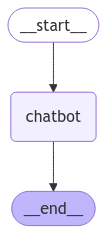

Assistant: Hello Hassaan, it's nice to meet you. Is there something I can help you with or would you like to chat?
Assistant: I don't know your name. I'm a large language model, I don't have the ability to know your personal information or recall previous conversations. Each time you interact with me, it's a new conversation. If you'd like to share your name, I'd be happy to chat with you and use it in our conversation!
Assistant: Today's date is March 22, 2025.


In [18]:
# Part 1 - Building a basic chatbot

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from IPython.display import Image, display


groq_api_key = "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"

# * The class "State" is a dict based on TypedDict; this means that we can specify
# which keys and what "type" of values it can have. We have defined it to have only 
# one key i.e. "messages" and the type of its value to be a list.
# * The `add_messages` function in the annotation defines how this state should be updated:
# we can only append messages to the list, not overwrite them.
# * However, in our current implementation, we are not saving the state anywhere; when we
# execute graph.stream(...), it initiates the graph with a new state.
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)

def chatbot(state: State):
    # print(state)
    return {"messages": [llm.invoke(state["messages"])]}


# * The first argument is the unique node name
# * The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


# * In this case, we have only one node - hence, we would get only one output / event from graph.stream;
# but if we had multiple nodes, we would get multiple outputs / events i.e. one output for each node.
# * "event" is a dictionary containing the output of a node; its key is the name of that node e.g. "chatbot" and
# its values are the list of dictionaries returned by the chatbot function.
# * Our "chatbot" node is returning only a single dictionary, hence the list "event.values()" contains a
# single dictionary: {"messages": [llm.invoke(state["messages"])]}
# * In the dictionary {"messages": [llm.invoke(state["messages"])]}, the value stored against the "messages" key 
# is a list; in our case, we can see that this list contains a single item only i.e. the response of the llm.
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

i = 0
while True:
    try:
        # user_input = input("User: ")
        # if user_input.lower() in ["quit", "exit", "q"]:
        #     print("Goodbye!")
        #     break
        if i==0: user_input = "My name is Hassaan."
        if i==1: user_input = "What's my name?"
        if i==2: user_input = "What's the date today?" # llama3.3-70b hosted on groq fetches the actual date!
        stream_graph_updates(user_input)
        if i==2: break
        i += 1
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [ ]:
# Part 2(a) - using custom BasicToolNode and route_tools (instead of the prebuilt ToolNode and tools_condition, respectively) - for learning purposes

from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_core.messages import ToolMessage
import os
import json


os.environ["TAVILY_API_KEY"] = "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"
tool = TavilySearchResults(max_results=2)
tools = [tool]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

groq_api_key = "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"
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        
        # This creates a dictionary containing each tool name as the key and the tool itself as the value against that key
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # := is the walrus operator
        # It assigns the value inputs.get("messages", []) to "messages" variable inside the "if" condition.
        # If "messages" variable does not come out to be an empty list, the latest message (i.e. AIMessage) is assigned to
        # "message" variable. The "chatbot" we defined above outputs only a single msg i.e. the response of the LLM (llm_with_tools).
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        # The LLM's tool-calling support and binding the llm to the tools (llm.bind_tools - see above) results in tool_calls being added to the AIMEssage.
        # Each tool call contains the name of the tool that the LLM wants to call, the input ("args") to be fed to that tool as well as an ID for that tool call.
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # For each tool call, we get the output of the relevant tool and append it to the "outputs" list.
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# We initialize the BasicToolNode class using the list of tools (see __init__ method of the class BasicToolNode)
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to 
# route to different nodes depending on the current graph state. These functions receive the current graph state and return 
# a string or list of strings indicating which node(s) to call next. In our case, we are returning just a string i.e. either
# "tools" or END.
# Below, define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this 
# function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes, 
# check this function to see where to go next.
# The condition will route to tools if tool calls are present and END if not.
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge (add_conditional_edges) to route to the tool node(BasicToolNode) if the last message
    has tool calls. Otherwise, route to the end.
    """
    # This function gets, as an input, the output of the "chatbot" node - which has the same type as the class "State".
    # The first condition (if isinstance) would have held true if we had defined the chatbot node's output to be a list. 
    # However, we have defined its output to be a dictionary whose key is "messages" and whose value is a list 
    # containing a single message i.e. the LLM's response.
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `route_tools` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node.
    # It defaults to the identity function (i.e. value=key), but if we want to use a node named something else apart from "tools",
    # we can update the value of the dictionary to something else e.g. "tools": "my_tools".
    # NOTE: However, DON'T use the identify function if the key/value are going to be sth other than "tools"! That would
    # cause the code to silently fail / prevent the generation of graph's image (see code below: display(Image...)).
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     pass

def stream_graph_updates(user_input: str):
    # Here, there are two nodes i.e. "chatbot" and "tools". So, we get the following events:
    # - chatbot's call to tools node
    # - tools node's output
    # - chatbot's response based on tools node's output
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

i = 0
while True:
    if i==0: user_input = "What's the date today? Find it online."
    stream_graph_updates(user_input)
    if i==0: break
    i += 1

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_624e', 'function': {'arguments': '{"query": "current date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 288, 'total_tokens': 307, 'completion_time': 0.069090909, 'prompt_time': 0.025676741, 'queue_time': 0.24843861699999997, 'total_time': 0.09476765}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c4760ee73b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d1138a1-5f57-4c95-9f24-a829e7079cf8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current date'}, 'id': 'call_624e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 19, 'total_tokens': 307})]}}
Assistant: 
{'tools': {'messages': [ToolMessage(content='[{"title": "What Is Today\'s Date? - Inch Calculator", "url": "https://www.inchcalculator.com/what-is-todays-

In [ ]:
# Part 2(b) - using the prebuilt ToolNode and tools_condition - NOTE: these do some nice things like parallel API execution

from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

import os
import json


os.environ["TAVILY_API_KEY"] = "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"
tool = TavilySearchResults(max_results=2)
tools = [tool]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

groq_api_key = "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"
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# The `tools_condition` function directs the control flow towards either the "tools" node or END.
# Note that tools_condition is a prebuilt function; hence, we are required to use the name "tools" for our tools node;
# custom name is not allowed.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")
graph_builder.set_entry_point("chatbot") # serves the same purpose as the above line
graph = graph_builder.compile()

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(f"error: {str(e)}")

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content, "\n")

i = 0
while True:
    if i==0: user_input = "What's the date today? Find it online."
    stream_graph_updates(user_input)
    if i==0: break
    i += 1

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6p94', 'function': {'arguments': '{"query": "current date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 288, 'total_tokens': 307, 'completion_time': 0.069090909, 'prompt_time': 0.019130655, 'queue_time': 0.24759852, 'total_time': 0.088221564}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_90c1d253ff', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-584c6955-8a7f-4b94-9b1e-c794b2cf0599-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current date'}, 'id': 'call_6p94', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 19, 'total_tokens': 307})]}}
Assistant:  

{'tools': {'messages': [ToolMessage(content='[{"title": "What Is Today\'s Date? - Inch Calculator", "url": "https://www.inchcalculator.com/what-is-todays-date/"

In [ ]:
# Part 3 - Adding Memory to the Chatbot

from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

import os
import json

# Here, we're using an in-memory checkpointer. In a production application, change this to use SqliteSaver or PostgresSaver and connect to DB
memory = MemorySaver()

os.environ["TAVILY_API_KEY"] = "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"
tool = TavilySearchResults(max_results=2)
tools = [tool]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

groq_api_key = "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"
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    groq_api_key = groq_api_key
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot") # serves the same purpose as the above line

# Compile the graph with the provided checkpointer. This enables the graph to save the current state to memory.
graph = graph_builder.compile(checkpointer=memory)

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(f"error: {str(e)}")

# pick a thread to use as the key for this conversation
config_1 = {"configurable": {"thread_id": "1"}}
config_2 = {"configurable": {"thread_id": "2"}}

def stream_graph_updates(user_input: str, config):
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        # The thread specified in config variable is used to identify whether to load an earlier state or initiate a fresh state.
        # If we use the same configs / thread_ids for subsequent queries, the graph would load the earlier state and hence
        # remember our conversation history.
        config,
        stream_mode="values",
        )
    for event in events:
        print(snapshot.next)
        event["messages"][-1].pretty_print()

i = 0
while True:
    if i==0: 
        user_input = "My name is Hassaan."
        stream_graph_updates(user_input, config_1)
        snapshot = graph.get_state(config_1)
        print(snapshot)
        # print(snapshot.next)
    if i==1: 
        user_input = "What's the date today? Find it online"
        stream_graph_updates(user_input, config_1)
        snapshot = graph.get_state(config_1)
        print(snapshot)
        # print(snapshot.next)
    if i==1: break
    i += 1

    # TODO: WHERE SHOULD I WRITE SNAPSHOT.NEXT SO THAT I KNOW WHICH NODE WILL EXECUTE NEXT?????????????

()
================================ Human Message =================================

My name is Hassaan.
()
================================== Ai Message ==================================

Hello Hassaan, it's nice to meet you. Is there something I can help you with or would you like to chat?
StateSnapshot(values={'messages': [HumanMessage(content='My name is Hassaan.', additional_kwargs={}, response_metadata={}, id='72d75f34-f0d9-4a25-9e31-e6c53b184d30'), AIMessage(content="Hello Hassaan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 284, 'total_tokens': 311, 'completion_time': 0.098181818, 'prompt_time': 0.017994629, 'queue_time': 0.058698941000000004, 'total_time': 0.116176447}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_41c250edc7', 'finish_reason': 'stop', 'logprobs': None}, id='run-ca24ac84-05e0-4ae9-984a-cf4c570cc